<a href="https://colab.research.google.com/github/kitaef/dls_final_project/blob/main/dls_final_project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
accelerator = 'gpu'
if accelerator == 'tpu':
    !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.debug.metrics as met
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.utils.utils as xu    
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F   
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() and accelerator == 'gpu' else xm.xla_device()

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set
# !kaggle datasets download -d dullaz/flickrfaces-dataset-nvidia-128x128
# !kaggle datasets download -d kitaef/41-epochs-faces
!unzip -n /content/cartoon-faces-googles-cartoon-set.zip
# !unzip -n /content/flickrfaces-dataset-nvidia-128x128.zip
# !unzip -n /content/41-epochs-faces.zip
!kaggle datasets download -d almightyj/person-face-dataset-thispersondoesnotexist
!unzip -n /content/person-face-dataset-thispersondoesnotexist.zip

In [ ]:
# !kaggle datasets download -d almightyj/person-face-dataset-thispersondoesnotexist
# !unzip -n /content/person-face-dataset-thispersondoesnotexist.zip

In [36]:
class ImageDS(Dataset):
    
    def __init__(self, path_a, path_b, image_size):
        super().__init__()
        self.image_size = image_size
        self.images_a = self.process_folder(path_a, crop='cartoon')
        self.images_b = self.process_folder(path_b, crop='face')
        self.size_a = len(self.images_a)
        self.size_b = len(self.images_b)
        self.bigger = True if self.size_a >= self.size_b else False
        
    def process_folder(self, path, crop):
        images = []
#         file_names = os.listdir(path)
#         if DATASET_SIZE != -1:
#             file_names = file_names[:DATASET_SIZE]
#         for fname in tqdm(file_names):
        progress_bar = tqdm(total=DATASET_SIZE, desc='Images processed:', position=0)      
        for dirname, _, filenames in os.walk(path):
            if len(images) >= DATASET_SIZE:
                    break
            for filename in filenames:
                if len(images) >= DATASET_SIZE:
                    break
                if filename.endswith('.jpg') or filename.endswith('.png'):
            #                 f_path = path + fname
            #                 image = Image.open(f_path)
            #                 if image.getbands() == ('R', 'G', 'B'):
                    image = Image.open(os.path.join(dirname, filename))
                    progress_bar.update(1)
                    scale = 1.6 if crop == 'cartoon' else 1.0
                    transform = tt.Compose([
                            tt.Resize(int(self.image_size * scale)),
                            tt.CenterCrop(self.image_size),
                            tt.RandomHorizontalFlip(),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                    image = transform(image)
                    images.append(image)
                    
#                     clear_output()
#                     print(len(images), '/', DATASET_SIZE, sep='')
                    if len(images) >= DATASET_SIZE:
                        break
                
        return images
        
    
    def __len__(self):
        return self.size_a if self.bigger else self.size_b
    
    def __getitem__(self, index):
        if self.bigger:
            image_a = self.images_a[index]
            image_b = self.images_b[int(index * (self.size_b / self.size_a))]
        else:
            image_a =  self.images_a[int(index * (self.size_a / self.size_b))]
            image_b =  self.images_b[index]
            
        return image_a, image_b
# # Apples2oranges
# path_tr_a = '../input/apple2orange-dataset/trainA/'
# path_tr_b ='../input/apple2orange-dataset/trainB/'
# path_tst_a = '../input/apple2orange-dataset/testA/'
# path_tst_b = '../input/apple2orange-dataset/testB/'

# # Monet2photo
# path_tr_a = '../input/monet2photo/trainA/'
# path_tr_b ='../input/monet2photo/trainB/'
# path_tst_a = '../input/monet2photo/testA/'
# path_tst_b = '../input/monet2photo/testB/'

# cars2toys
# path_tr_a = '../input/stanford-cars-dataset/cars_train/cars_train/'
# path_tr_b = '../input/toy-cars-annotated-on-yolo-format/'

# faces2cartoons
# path_tr_a = '../input/cartoon-faces-googles-cartoon-set/'
# path_tr_b ='../input/flickrfaces-dataset-nvidia-128x128/real_faces_128/'
path_tr_a = '/content/cartoonset100k_jpg'
path_tr_b ='/content/thispersondoesnotexist.10k'


IMAGE_SIZE = 64
BATCH_SIZE = 10
DATASET_SIZE = 10000

train_ds = ImageDS(path_tr_a, path_tr_b, IMAGE_SIZE)
# test_ds = ImageDS(path_tst_a, path_tst_b, IMAGE_SIZE)

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
# test_dl = DataLoader(test_ds, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

Images processed::   0%|          | 0/10000 [00:00<?, ?it/s]

Images processed::   0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
print(train_ds.size_a, train_ds.size_b)

5000 5000


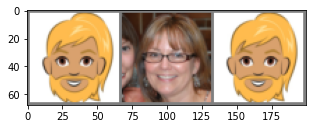

In [43]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def show(a, b, c):
    plt.figure(figsize=(5,2))
    plt.imshow(denorm(make_grid(torch.cat((a[:1], b[:1], c[:1]), dim=0), nrow=6).permute(1,2,0)))
    plt.show()
# images_a = torch.empty(0,3,image_size, image_size)
# images_b = torch.empty(0,3,image_size, image_size)
# for _ in range(12):
#     image_a, image_b = next(iter(train_dl))
#     images_a = torch.vstack((images_a, image_a))
#     images_b = torch.vstack((images_b, image_b))
a, b = next(iter(train_dl))
c = a
show(a, b, c)

In [ ]:
def conv_block(in_ch, out_ch, kernel=3, stride=2, padding=1, normalize=True, activation=nn.LeakyReLU(0.2, inplace=True)):
    layers = [nn.ReflectionPad2d(padding)] if padding > 0 else []
    layers += [nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=0)]
    if normalize:
        layers += [nn.BatchNorm2d(out_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(out_ch, affine=True)]
    if activation:
        layers += [activation]
    return layers

def deconv_block(in_ch, out_ch,
                 kernel=3, stride=1, padding=1,
                 normalize=True,
                 activation=True):
    layers = [nn.Upsample(scale_factor = 2, mode='bilinear'),
              nn.ReflectionPad2d(padding),
              nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=0)]
    if normalize:
        layers += [nn.BatchNorm2d(out_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(out_ch, affine=True)]
    if activation:
        layers += [nn.ReLU(inplace=True)]
    return layers
    
class Res_block(nn.Module):
    
    def __init__(self, in_ch):
        super().__init__()
        self.block = nn.Sequential(nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_ch, in_ch, kernel_size=3),
                                   nn.BatchNorm2d(in_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(in_ch, affine=True),
                                   nn.ReLU(inplace=True),
                                   nn.ReflectionPad2d(1),
                                   nn.Conv2d(in_ch, in_ch, kernel_size=3),
                                   nn.BatchNorm2d(in_ch, affine=True) if BATCH_SIZE > 1 else nn.InstanceNorm2d(in_ch, affine=True)
                                  )
    def forward(self, x):
        return x + self.block(x)
    
    
class Discriminator(nn.Module):
    
    def __init__(self, in_ch=3, features=[64, 128, 256, 512]):
        super().__init__()
        layers = []
        for out_ch in features:
            layers += conv_block(in_ch, out_ch, kernel=4)
            in_ch = out_ch
        layers += conv_block(features[-1], 1, kernel=4, stride=1, padding=0, normalize=False, activation=nn.Sigmoid())
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x).view(-1, 1)
    
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        layers = []
        layers += conv_block(3, 64, kernel=7, stride=1, padding=3, activation=nn.ReLU(inplace=True))
        layers += conv_block(64,128, activation=nn.ReLU(inplace=True))
        layers += conv_block(128,256, activation=nn.ReLU(inplace=True))
        layers += [Res_block(256)] * 5
        layers += deconv_block(256, 128, activation=nn.ReLU(inplace=True))
        layers += deconv_block(128, 64, activation=nn.ReLU(inplace=True))
        layers += conv_block(64, 3, kernel=7, stride=1, padding=3, normalize=False, activation=nn.Tanh())
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
        
def test():
    D = Discriminator()
    G = Generator()
    test = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
    print(D(test).shape)
    print(G(test).shape)
    print(D)
    print(G)
    
test()


In [30]:
import itertools
import random

class DecayLR:
    def __init__(self, epochs, offset, decay_epochs):
        epoch_flag = epochs - decay_epochs
        assert (epoch_flag > 0), "Decay must start before the training session ends!"
        self.epochs = epochs
        self.offset = offset
        self.decay_epochs = decay_epochs

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_epochs) / (
                self.epochs - self.decay_epochs)
    
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

device='cpu'
# create model
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

netG_A2B.load_state_dict(torch.load('/content/drive/MyDrive/DLS FINAL/5000_G_A2B'))
netG_B2A.load_state_dict(torch.load('/content/drive/MyDrive/DLS FINAL/5000_G_B2A'))
# netD_A.load_state_dict(torch.load('/content/drive/MyDrive/DLS FINAL/5000_D_A'))
# netD_B.load_state_dict(torch.load('/content/drive/MyDrive/DLS FINAL/5000_D_B'))

<All keys matched successfully>

In [25]:
# torch.save(netG_A2B.cpu().state_dict(), './1final_' + 'G_A2B')
# torch.save(netG_B2A.cpu().state_dict(), './1final_' + 'G_B2A')
# torch.save(netD_A.cpu().state_dict(), './1final_' + 'D_A')
# torch.save(netD_B.cpu().state_dict(), './1final_' + 'D_B')

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: ignored

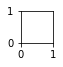

In [48]:
# define loss function (adversarial_loss) and optimizer
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)
lr=0.0002
epochs = 10
decay_epochs = 0
# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                               lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

lr_lambda = DecayLR(epochs, 0, decay_epochs).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)
# scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=7, gamma=0.8)
# scheduler_DA = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=7, gamma=0.8)
# scheduler_DB = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=7, gamma=0.8)

g_losses = []
d_losses = []

identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

for epoch in range(0, epochs):
    progress_bar = tqdm(enumerate(train_dl), total=len(train_dl))
    for i, data in progress_bar:
        netG_A2B.train()
        netG_B2A.train()
        netD_A.train()
        netD_B.train()
        # get batch size data
        real_image_A = data[0].to(device)
        real_image_B = data[1].to(device)
        batch_size = real_image_A.size(0)

        # real data label is 1, fake data label is 0.
        real_label = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32).uniform_(0.8, 1.0)
        fake_label = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32).uniform_(0., 0.2)

        ##############################################
        # (1) Update G network: Generators A2B and B2A
        ##############################################

        # Set G_A and G_B's gradients to zero
        optimizer_G.zero_grad()

        # Identity loss
        # G_B2A(A) should equal A if real A is fed
        identity_image_A = netG_B2A(real_image_A)
        loss_identity_A = identity_loss(identity_image_A, real_image_A) * 4.0
        # G_A2B(B) should equal B if real B is fed
        identity_image_B = netG_A2B(real_image_B)
        loss_identity_B = identity_loss(identity_image_B, real_image_B) * 4.0

        # GAN loss
        # GAN loss D_A(G_A(A))
        fake_image_A = netG_B2A(real_image_B)
        fake_output_A = netD_A(fake_image_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
        # GAN loss D_B(G_B(B))
        fake_image_B = netG_A2B(real_image_A)
        fake_output_B = netD_B(fake_image_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)

        # Cycle loss
        recovered_image_A = netG_B2A(fake_image_B)
        loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 2.0

        recovered_image_B = netG_A2B(fake_image_A)
        loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 2.0

        # Combined loss and calculate gradients
        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        g_losses.append(errG.item())
        # Calculate gradients for G_A and G_B
        errG.backward()
        # Update G_A and G_B's weights
        if accelerator == 'tpu':
            xm.mark_step()
        else:
            optimizer_G.step()


        ##############################################
        # (2) Update D network: Discriminator A
        ##############################################

        # Set D_A gradients to zero
        optimizer_D_A.zero_grad()

        # Real A image loss
        real_output_A = netD_A(real_image_A)
        errD_real_A = adversarial_loss(real_output_A, real_label)

        # Fake A image loss
        fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
        fake_output_A = netD_A(fake_image_A.detach())
        errD_fake_A = adversarial_loss(fake_output_A, fake_label)

        # Combined loss and calculate gradients
        errD_A = (errD_real_A + errD_fake_A)

        # Calculate gradients for D_A
        errD_A.backward()
        # Update D_A weights
        if accelerator == 'tpu':
            xm.mark_step()
        else:
            optimizer_D_A.step()


        ##############################################
        # (3) Update D network: Discriminator B
        ##############################################

        # Set D_B gradients to zero
        optimizer_D_B.zero_grad()

        # Real B image loss
        real_output_B = netD_B(real_image_B)
        errD_real_B = adversarial_loss(real_output_B, real_label)

        # Fake B image loss
        fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
        fake_output_B = netD_B(fake_image_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_label)

        # Combined loss and calculate gradients
        errD_B = (errD_real_B + errD_fake_B)

        # Calculate gradients for D_B
        errD_B.backward()
        # Update D_B weights
        if accelerator == 'tpu':
            xm.mark_step()
        else:
            optimizer_D_B.step()
        d_losses.append((errD_A + errD_B).item())
        progress_bar.set_description(
            f"[{epoch+1}/{epochs}][{i+1}/{len(train_dl)}] "
            f"Loss_D: {(errD_A + errD_B).item():.4f} "
            f"Loss_G: {errG.item():.4f} "
            f"Loss_G_identity: {(loss_identity_A + loss_identity_B).item():.4f} "
            f"loss_G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f} "
            f"loss_G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}")
#     clear_output()
        # save models
        
        if (i+1) % 200 == 0:
            model_path = f'/content/drive/MyDrive/DLS FINAL/{epoch+1}_{i + 1}_'
            torch.save(netG_A2B.cpu().state_dict(), model_path + 'G_A2B')
            torch.save(netG_B2A.cpu().state_dict(), model_path + 'G_B2A')
            torch.save(netD_A.cpu().state_dict(), model_path + 'D_A')
            torch.save(netD_B.cpu().state_dict(), model_path + 'D_B')
            netG_A2B.to(device)
            netG_B2A.to(device)
            netD_A.to(device)
            netD_B.to(device)

        # show results
        if (i + 1) % 5 == 0:
            iterator = iter(train_dl)
            images_a, images_b = next(iterator)
            images_a_real = images_a.to(device)[0:3,:,:,:]
            images_b_real = images_b.to(device)[0:3,:,:,:]
            netG_A2B.eval()
            netG_B2A.eval()
            netD_A.eval()
            netD_B.eval()
            with torch.no_grad():
                a2b_transformed = netG_A2B(images_a_real)
                b2a_transformed = netG_B2A(images_b_real)
                a2b2a_recovered = netG_B2A(a2b_transformed)
                b2a2b_recovered = netG_A2B(b2a_transformed)
            plt.figure(figsize=(17,7))
            grid = plt.GridSpec(9, 4, wspace = .1, hspace = .35)
            for i in range(1,4):
              plt.subplot(grid[i-1:i, 0:2])
              plt.imshow(denorm(make_grid(torch.cat((images_a_real[i-1].detach().cpu(),
                                                    a2b_transformed[i-1].detach().cpu(),
                                                    a2b2a_recovered[i-1].detach().cpu()), dim=0), nrow=6
                                        )
                              )
                        )
              plt.axis('off')
              plt.subplot(grid[i-1:i, 2:4])
              plt.imshow(denorm(make_grid(torch.cat((images_b_real[i-1].detach().cpu(),
                                                    b2a_transformed[i-1].detach().cpu(),
                                                    b2a2b_recovered[i-1].detach().cpu()), dim=0), nrow=6
                                        )
                              )
                        )
              plt.axis('off')
            plt.subplot(grid[3:9, 0:4])
            plt.plot(g_losses, label="G")
            plt.plot(d_losses, label="D")
            plt.legend()
            plt.suptitle(t=f'Batch {i+1}/{len(train_dl)/BATCH_SIZE:.0f}:',
                      y=0.95, x=0.5)
            plt.show()    
#             show(images_a_real.detach().cpu(), a2b_transformed.detach().cpu(), a2b2a_recovered.detach().cpu())
#             show(images_b_real.detach().cpu(), b2a_transformed.detach().cpu(), b2a2b_recovered.detach().cpu())
    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
torch.save(netG_A2B.cpu().state_dict(), './new_' + 'G_A2B')
torch.save(netG_B2A.cpu().state_dict(), './new_' + 'G_B2A')
torch.save(netD_A.cpu().state_dict(), './new_' + 'D_A')
torch.save(netD_B.cpu().state_dict(), './new_' + 'D_B')
netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

Discriminator(
  (conv): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(128, 1, kernel_size=(8, 8), stride=(1, 1))
    (13): Sigmoid()
  )
)